In [7]:
import numpy as np 
import networkx as nx 
import os 
import matplotlib.pyplot as plt
%matplotlib inline

### Head-To-Head Comparison of Micro-AND and Macro-AND

First thing we need to do is read in all the relevant outputs from the PID analysis:

In [8]:
micro_lattice = nx.read_edgelist("AND_micro_lattice.edgelist")
macro_lattice = nx.read_edgelist("AND_macro_lattice.edgelist")

micro_pid = np.load("AND_micro_PID_dicts.npz", allow_pickle=True)
micro_lattice_nums = micro_pid["arr_0"][0]
micro_lattice_terms = micro_pid["arr_0"][1]

macro_pid = np.load("AND_macro_PID_dicts.npz", allow_pickle=True)
macro_lattice_nums = macro_pid["arr_0"][0]
macro_lattice_terms = macro_pid["arr_0"][1]

We can find the "level" of each PI atom by counting how far they are from the top of the lattice. 

In [9]:
micro_paths = dict(nx.shortest_paths.single_source_dijkstra_path_length(micro_lattice, "{0:1:2:3}"))
macro_paths = dict(nx.shortest_paths.single_source_dijkstra_path_length(macro_lattice, "{0:1:2}"))

Here, total_micro and total_macro are the total amounts of past-future MI at each scale.

In [10]:
total_micro = max([x[0] for x in micro_lattice_terms.values()])
total_macro = max([x[0] for x in macro_lattice_terms.values()])

for node in micro_lattice.nodes:
    micro_lattice.nodes[node]["pi_term"] = micro_lattice_terms[node][1] / total_micro
    micro_lattice.nodes[node]["level"] = micro_paths[node]
    
for node in macro_lattice.nodes:
    macro_lattice.nodes[node]["pi_term"] = macro_lattice_terms[node][1] / total_macro
    macro_lattice.nodes[node]["level"] = macro_paths[node]

In [11]:
print("Micro Total", total_micro, "bit")
print("Macro Total", total_macro, "bit")

Micro Total 1.6226 bit
Macro Total 0.8113 bit


Clearly very lossy compression going from micro-AND to macro-AND. Since these are clearly not on the same playing field, I am going to look at normalized PI terms (i.e. what percentage of the MI is in a given atom, vs. the absolute number of bits).

Below I attempt to plot the lattices. Networkx native drawing utility is not great, I will play with Gephi. 

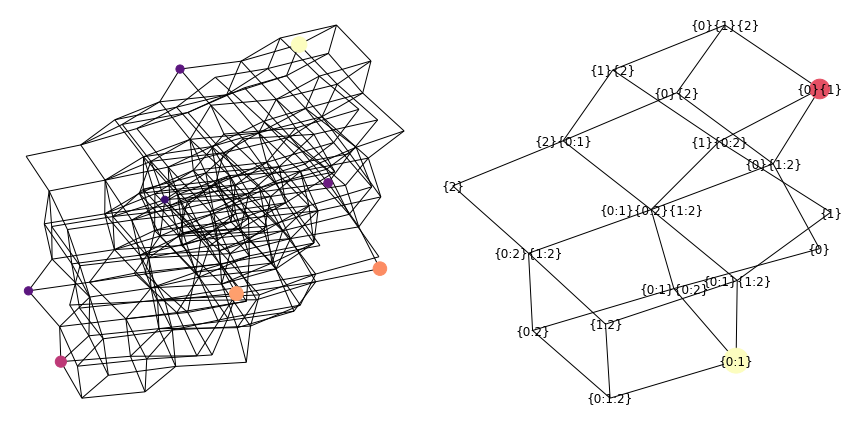

In [12]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
micro_size = [1000*x for x in nx.get_node_attributes(micro_lattice, "pi_term").values()]
nx.draw_kamada_kawai(micro_lattice,
                     node_color=list(nx.get_node_attributes(micro_lattice, "pi_term").values()),
                     node_size=micro_size,
                     cmap="magma")

plt.subplot(1,2,2)
macro_size = [1000*x for x in nx.get_node_attributes(macro_lattice, "pi_term").values()]
nx.draw_kamada_kawai(macro_lattice,
                     node_color=list(nx.get_node_attributes(macro_lattice, "pi_term").values()),
                     node_size=macro_size,
                     cmap="magma",
                     with_labels=True)
plt.tight_layout()

In [13]:
micro_synergy = sum([micro_lattice.nodes[node]["pi_term"] for node in micro_lattice if micro_lattice.nodes[node]["level"] < 7])
micro_redundancy = sum([micro_lattice.nodes[node]["pi_term"] for node in micro_lattice if micro_lattice.nodes[node]["level"] >= 7])

In [14]:
print("Above The Middle (Micro):", 100*micro_synergy / (micro_synergy+micro_redundancy), "%")
print("Below the Middle (Micro):", 100*micro_redundancy / (micro_synergy+micro_redundancy), "%")

Above The Middle (Micro): 38.44447183532601 %
Below the Middle (Micro): 61.55552816467398 %


At the micro-scale, it seems like information is shared ~50/50 above and below the midline (because there will always be an odd number of layers, I assigned the "middle" layer with the unique terms to the lower half. This adds a slight bias to avoid the risk of over-estimating the synergistic information. 

In [15]:
macro_synergy = sum([macro_lattice.nodes[node]["pi_term"] for node in macro_lattice if macro_lattice.nodes[node]["level"] < 3])
macro_redundancy = sum([macro_lattice.nodes[node]["pi_term"] for node in macro_lattice if macro_lattice.nodes[node]["level"] >= 3])

In [16]:
print("Above The Middle (Macro):", 100*macro_synergy / (macro_synergy+macro_redundancy), "%")
print("Below the Middle (Macro):", 100*macro_redundancy / (macro_synergy+macro_redundancy), "%")

Above The Middle (Macro): 61.629483544927886 %
Below the Middle (Macro): 38.37051645507211 %


At the macro-scale, it looks like the information that was not lost is now biased towards being higher on the lattice. That's kind of neat.